# Feature Behavior Analysis (Pre-Modeling)

This notebook focuses on understanding how individual features behave
across normal and attack traffic before applying any machine learning.

The objective is not to build models, but to evaluate whether features
carry meaningful, stable, or misleading signals.

This step is critical to avoid premature modeling and false confidence
based on noisy or overlapping features.


## Why Feature Behavior Analysis Matters

Machine learning models can appear to perform well even when underlying
features are weak, unstable, or misleading.

By analyzing feature behavior beforehand, we aim to:
- Identify features with genuine signal
- Detect features dominated by noise or outliers
- Avoid features that separate visually but fail statistically


In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")


In [41]:
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False


In [42]:
data1 = pd.read_csv(r"D:\MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv")
data2 = pd.read_csv(r"D:\MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv")
data3 = pd.read_csv(r"D:\MachineLearningCVE\Wednesday-workingHours.pcap_ISCX.csv")
data4 = pd.read_csv(r"D:\MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
data5 = pd.read_csv(r"D:\MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
data6 = pd.read_csv(r"D:\MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv")
data7 = pd.read_csv(r"D:\MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
data8 = pd.read_csv(r"D:\MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

data = pd.concat(
    [data1, data2, data3, data4, data5, data6, data7, data8],
    ignore_index=True
)


In [43]:
# Remove leading/trailing whitespace from column names
data.columns = data.columns.str.strip()

In [44]:
missing_counts = data.isna().sum()
missing_counts[missing_counts > 0]

Flow Bytes/s    1358
dtype: int64

In [45]:
data_before = data.shape[0]
data.dropna(inplace=True)
data_after = data.shape[0]

print(f"Rows before: {data_before}")
print(f"Rows after: {data_after}")

Rows before: 2830743
Rows after: 2829385


In [46]:
dup_before = data.shape[0]
data.drop_duplicates(inplace=True)
dup_after = data.shape[0]

print(f"Rows before duplicate removal: {dup_before}")
print(f"Rows after duplicate removal: {dup_after}")

Rows before duplicate removal: 2829385
Rows after duplicate removal: 2522009


In [47]:
data.columns = (
    data.columns
    .str.encode("ascii", errors="ignore")
    .str.decode("ascii")
)


In [48]:
print("Final cleaned dataset shape:", data.shape)

Final cleaned dataset shape: (2522009, 79)


In [49]:
label_col = 'Label'
normal_data = data[data[label_col] == 'BENIGN']
attack_data = data[data[label_col] != 'BENIGN']


## Feature Selection Rationale

The following features were selected based on interpretability,
relevance to network behavior, and frequent use in intrusion detection
literature.

Selection prioritizes understanding over optimization.


In [50]:
features = [
    'Flow Duration',
    'Total Fwd Packets',
    'Total Backward Packets',
    'Total Length of Fwd Packets',
    'Flow Bytes/s'
]


### Why These Features?

- **Flow Duration** captures session-level behavior and persistence
- **Packet counts** reflect interaction intensity and symmetry
- **Packet length and bytes/sec** indicate throughput and potential abuse

These features are fundamental, interpretable, and meaningful without
requiring transformation.


In [51]:
label_col = 'Label'
normal_data = data[data[label_col] == 'BENIGN']
attack_data = data[data[label_col] != 'BENIGN']


In [52]:
summary_stats = []

for feature in features:
    stats = {
        "feature": feature,
        "normal_mean": normal_data[feature].mean(),
        "attack_mean": attack_data[feature].mean(),
        "normal_std": normal_data[feature].std(),
        "attack_std": attack_data[feature].std()
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
summary_df


,feature,normal_mean,attack_mean,normal_std,attack_std
0,Flow Duration,1.215399e+07,3.838617e+07,3.117703e+07,4.463581e+07
1,Total Fwd Packets,1.137074e+01,4.896627e+00,8.711280e+02,2.105305e+01
2,Total Backward Packets,1.307937e+01,4.126222e+00,1.159014e+03,1.890793e+01
3,Total Length of Fwd Packets,6.835779e+02,2.576880e+02,1.107233e+04,7.748301e+03
4,Flow Bytes/s,inf,inf,NaN,NaN


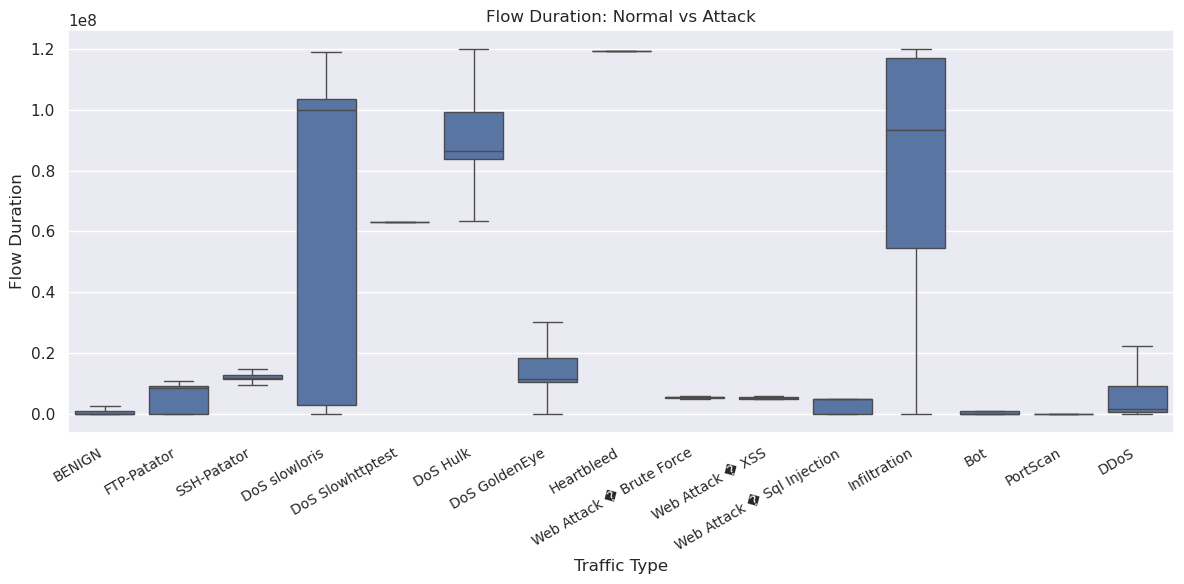

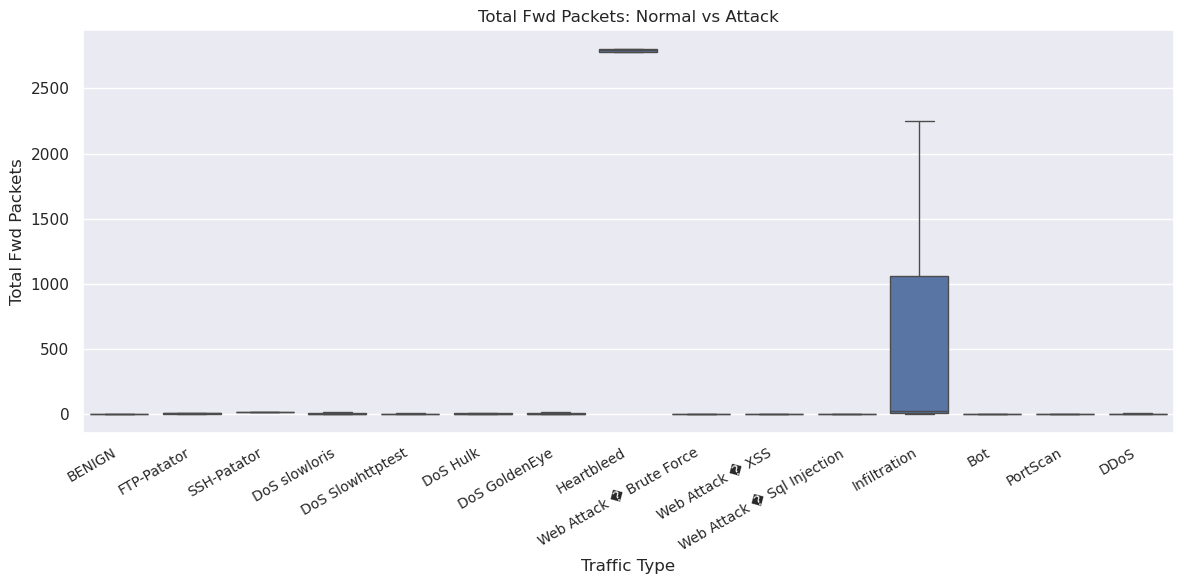

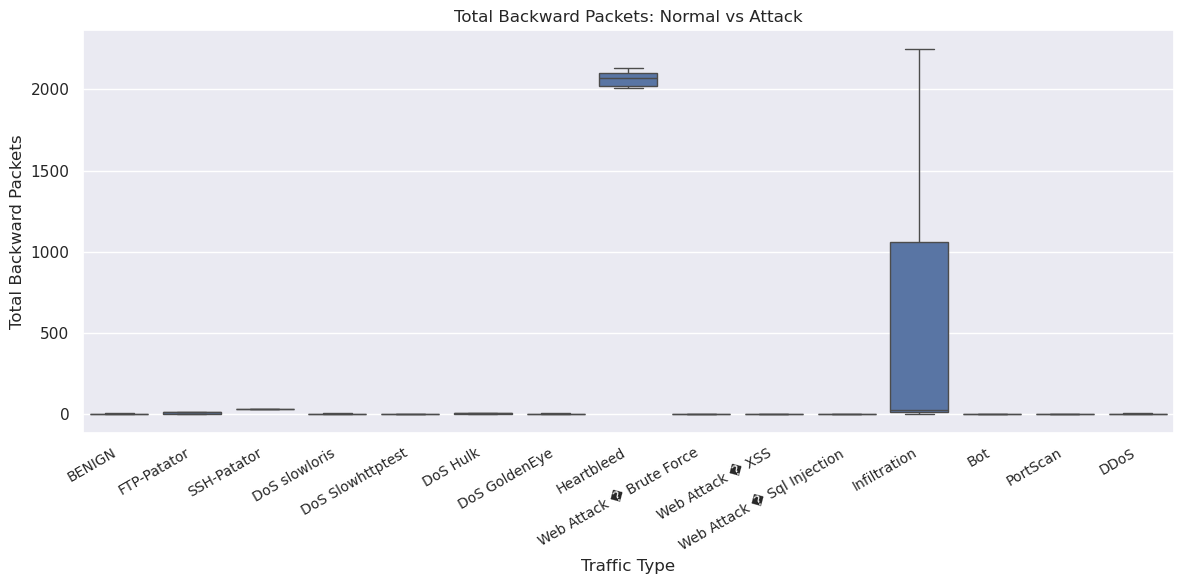

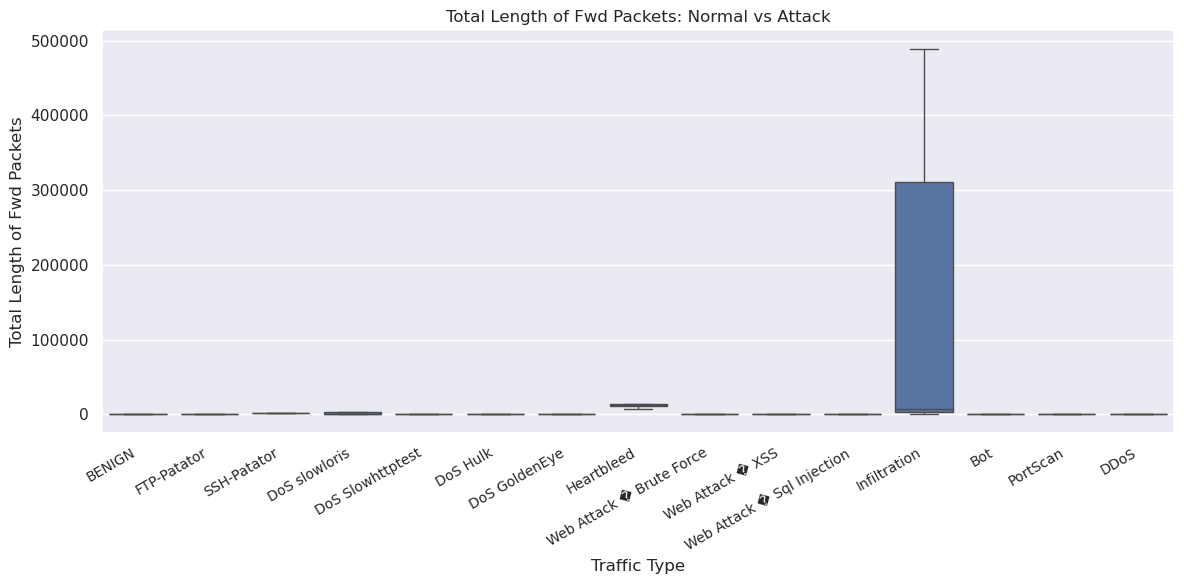

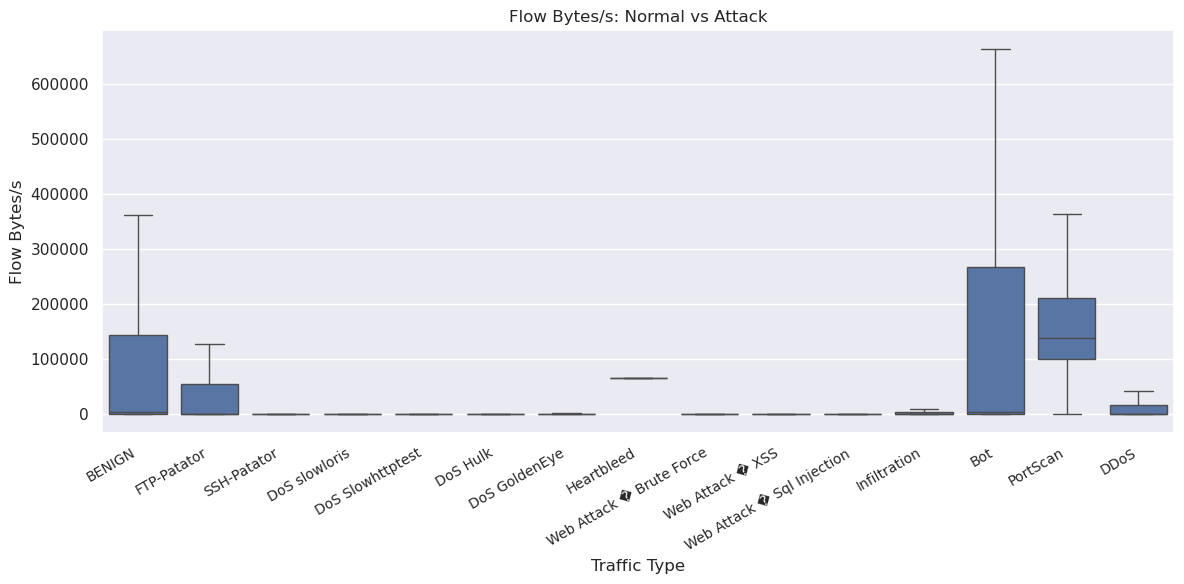

In [55]:
for feature in features:
    plt.figure(figsize=(12, 6))
    
    sns.boxplot(
        data=data,
        x=label_col,
        y=feature,
        showfliers=False
    )
    
    plt.title(f"{feature}: Normal vs Attack", fontsize=12)
    plt.xlabel("Traffic Type")
    plt.ylabel(feature)
    
    plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.tight_layout()
    plt.show()


### Initial Observations

- **Flow Duration:** Attack traffic shows broader spread, but with overlap.
- **Total Fwd Packets:** Higher variance in attacks, but median remains similar.
- **Total Backward Packets:** Noisy feature with weak separation.
- **Total Length of Fwd Packets:** Shows potential signal with wide dispersion.
- **Flow Bytes/s:** Appears visually separable but heavily influenced by outliers.


## Observational Summary (No Conclusions)

Based on feature-level inspection:

**Features showing some separation:**
- Flow Duration
- Total Length of Fwd Packets

**Features dominated by noise or overlap:**
- Total Backward Packets
- Flow Bytes/s

**Features that may mislead models:**
- Features with high variance and heavy tails
- Features that appear separable visually but overlap statistically

These observations highlight the importance of multi-feature reasoning
and caution against relying on individual metrics.
